# Definición del proyecto de datos

Todo este proyecto tiene su base en la obtención de ciertos insights a partir de 3 bases de datos, las cuales tiene como cobertura geográfica el estado de los ángeles de estados unidos, es decir, es un proyecto donde en particular se estudiara las relaciones entre las diferentes bases de datos donde la región a estudiar son los ángeles.

- Crimen

- Negocios

- Vivienda

El contexto, es simple, trabajamos para el gobierno como alcalde de la ciudad y por tanto, las decisiones que se tomen, deberán de ser tomadas con una perspectiva meramente política, por ello es que los objetivos de este análisis deben de centrarse en la obtención de accionables claros a partir de las relaciones e interacciones encontradas en las bases de datos.

Los ángeles se dividen en 114 vecindarios, sobre los cuales se deberán de realizar el análisis, es decir, la investigación es a nivel de vecindarios. Por tanto, un punto relevante es evaluar la granularidad de la información en las bases de datos así como preguntas de la siguiente naturaleza

¿Qué vecindarios tienen una mayor tasa de muerte de negocios?, ¿se relaciona con la tasa de crimen?
¿Qué vecindarios tienen la mayor tasa de crimen?, ¿necesitan mayor atención policial?
¿Está esto afectando a los precios de las propiedades?  

In [1]:
import pandas as pd 
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd                # Manejo de datos geoespaciales :contentReference[oaicite:8]{index=8}
from shapely.geometry import Point     # Construcción de geometrías puntuales :contentReference[oaicite:9]{index=9}

import requests
import io
from http.client import IncompleteRead

from sklearn.neighbors import BallTree

import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.oneway import test_scale_oneway
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.nonparametric import rank_compare_2indep

In [2]:
sns.set_style("darkgrid")
pd.options.display.float_format = "{:,.2f}".format

In [3]:
# URLs de descarga
crime_url    = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"      # Crimen 2020–Presente :contentReference[oaicite:10]{index=10}
business_url = "https://data.lacity.org/api/views/r4uk-afju/rows.csv?accessType=DOWNLOAD"     # Listado de negocios :contentReference[oaicite:11]{index=11}
neighborhoods_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD" # Vecindarios :contentReference[oaicite:12]{index=12} #https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0.geojson
# zhvi_url     = "~/work/Neighborhood_zhvi.csv"
zhvi_url     = "./resources/Neighborhood_zhvi.csv"# ZHVI mensual por vecindario :contentReference[oaicite:12]{index=12}
areas_url    = "https://geohub.lacity.org/datasets/691805703915458da4b35d8088f29501_0.geojson" # Área por vecindario :contentReference[oaicite:13]{index=13}
bounds_url   = "https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0.geojson" # Límites de vecindario :contentReference[oaicite:14]{index=14}
census_url   = "https://data.lacity.org/api/views/nwj3-ufba/rows.csv?accessType=DOWNLOAD"      # Censo 2010 por consejo :contentReference[oaicite:15]{index=15}


In [4]:
def fetch_csv_stream(url: str, timeout: int = 60) -> io.StringIO:
    """
    Descarga un CSV por streaming.  
    En caso de IncompleteRead, reutiliza los bytes parciales descargados.
    """
    try:
        resp = requests.get(url, stream=True, timeout=timeout)
        resp.raise_for_status()
        # Leer todo el texto (posible IncompleteRead aquí)
        text = resp.text
    except IncompleteRead as e:
        # e.partial es un bytes con lo descargado antes de la excepción
        print('Incompleto:', e.partial)
        text = e.partial.decode('utf-8', errors='replace')
    return io.StringIO(text)

# Negocios

## Definición de requerimientos de datos

En este caso nuestro objetivo es claro, enconetrar tendencias en la clasificación, edad, ubicación y distribución de los negocios. En esete sentido nuestro objetivo primordial es encontrar las relaciones claves entre los datos de los negocio y su ubicación o vecindario.

Por ende uno de los puntos claves es la busqueda de una relación entre el negocio y su vecindario.

In [5]:
business_bufer = fetch_csv_stream(business_url)

business_df = pd.read_csv(business_bufer, low_memory=False)

del business_bufer

In [6]:
business_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,"444,130.00",Hardware stores,0,10/01/2020,NaN,"(33.9581, -118.2926)"
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,NaN,NaN,8,09/03/2020,NaN,"(33.9597, -118.3028)"
2,0003249387-0001-0,"CHOE SHOW, LLC",NaN,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,711 GRAMERCY 90005,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,NaN,NaN,5,03/15/2021,NaN,"(34.0594, -118.3135)"
3,0003240128-0001-1,SANTOS ANTONIO RAMOS AJPACAJA,NaN,19948 SATICOY STREET,WINNETKA,91306-2648,19948 Saticoy 91306-2648,NaN,NaN,NaN,"561,790.00",Other services to buildings & dwellings,3,01/15/2019,NaN,"(34.2081, -118.5684)"
4,0003236037-0001-9,ASHLEY-ANN FELIX,NaN,412 W 7TH STREET,SAN PEDRO,90731-3208,412 7TH 90731,465 N HANFORD AVENUE,SAN PEDRO,90732-2621,NaN,NaN,15,03/01/2021,NaN,"(33.738, -118.2861)"


In [7]:
coord_col = 'LOCATION'


df_clean = business_df.dropna(subset=[coord_col]).copy()

# 2. Limpiar paréntesis y espacios sobrantes
coords = df_clean[coord_col].astype(str).str.strip('()')

# 3. Separar en dos columnas y convertir a tipo numérico
df_clean[['Latitude', 'Longitude']] = (
    coords
    .str.split(',', expand=True)        # separa en dos columnas
    .apply(lambda col: col.str.strip()) # quita espacios
    .astype(float)                      # convierte a float
)


gdf_business = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean['Longitude'], df_clean['Latitude']),
    crs="EPSG:4326"  # Coord. reference system GPS
)

gdf_business

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,"444,130.00",Hardware stores,0,10/01/2020,NaN,"(33.9581, -118.2926)",33.96,-118.29,POINT (-118.2926 33.9581)
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,NaN,NaN,8,09/03/2020,NaN,"(33.9597, -118.3028)",33.96,-118.30,POINT (-118.3028 33.9597)
2,0003249387-0001-0,"CHOE SHOW, LLC",NaN,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,711 GRAMERCY 90005,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,NaN,NaN,5,03/15/2021,NaN,"(34.0594, -118.3135)",34.06,-118.31,POINT (-118.3135 34.0594)
3,0003240128-0001-1,SANTOS ANTONIO RAMOS AJPACAJA,NaN,19948 SATICOY STREET,WINNETKA,91306-2648,19948 Saticoy 91306-2648,NaN,NaN,NaN,"561,790.00",Other services to buildings & dwellings,3,01/15/2019,NaN,"(34.2081, -118.5684)",34.21,-118.57,POINT (-118.5684 34.2081)
4,0003236037-0001-9,ASHLEY-ANN FELIX,NaN,412 W 7TH STREET,SAN PEDRO,90731-3208,412 7TH 90731,465 N HANFORD AVENUE,SAN PEDRO,90732-2621,NaN,NaN,15,03/01/2021,NaN,"(33.738, -118.2861)",33.74,-118.29,POINT (-118.2861 33.738)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607912,0003112677-0001-5,HEADLESS MUSICAL LLC,NaN,16830 VENTURA BLVD #400,ENCINO,91436-1726,16830 VENTURA 91436-1726,16830 VENTURA BLVD SUITE #400,ENCINO,91436-1726,"711,100.00",Performing arts companies,4,01/23/2019,NaN,"(34.1586, -118.5008)",34.16,-118.50,POINT (-118.5008 34.1586)
1607913,0003310793-0001-9,KARLA Y NEAL,NaN,4217 DALTON AVENUE,LOS ANGELES,90062-1809,4217 Dalton 90062-1809,NaN,NaN,NaN,"621,610.00",Home health care services,8,01/01/2020,12/31/2020,"(34.0068, -118.3038)",34.01,-118.30,POINT (-118.3038 34.0068)
1607914,0003469025-0001-8,DOMINIC MOISES PUAC MENCHU,SISTERS MC MULTISERVICES,4400 S BROADWAY SUITE #02,LOS ANGELES,90037-2791,4400 Broadway 90037-2791,141 W 45TH STREET,LOS ANGELES,90037-2796,"812,990.00",All other personal services,9,02/01/2025,NaN,"(34.0035, -118.2779)",34.00,-118.28,POINT (-118.2779 34.0035)
1607919,0003417591-0001-0,HERITAGE ELECTRIC INC,HERITAGE ELECTRIC,2175 GOODYEAR AVENUE SUITE #109,VENTURA,93003-7761,2175 GOODYEAR 93003-7761,223 LUCADA STREET ROOM,SANTA PAULA,93060,"235,310.00",Electrical Contractors (1997 NAICS),0,08/08/2020,NaN,"(34.2532, -119.2329)",34.25,-119.23,POINT (-119.2329 34.2532)


In [16]:
from shapely.geometry import Point

neighborhoods = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

neighborhoods

,OBJECTID,name,geometry
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0..."
1,2,Arleta,"POLYGON ((-118.44255 34.26412, -118.4424 34.26..."
2,3,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0..."
3,4,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788..."
4,5,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0..."
...,...,...,...
109,110,Wilmington,"MULTIPOLYGON (((-118.28331 33.75532, -118.2880..."
110,111,Windsor Square,"POLYGON ((-118.31404 34.06254, -118.3142 34.06..."
111,112,Winnetka,"POLYGON ((-118.56232 34.23199, -118.56232 34.2..."
112,113,Woodland Hills,"POLYGON ((-118.5724 34.18668, -118.57161 34.18..."


In [8]:
gdf_neigh = gpd.read_file('./resources/LAINC_6879240477164066125.geojson')

gdf_neigh = gdf_neigh.to_crs("EPSG:4326")

gdf_neigh.head()

,OBJECTID,zipcode,Rank,Neighborho,IRS_Ratio,HH_Size,Per_White,Per_Colleg,Rent,Index_Scor,...,College__1,Gross_Rent,Gross_Re_1,MedInc4,HHChangAdj,Population,Populati_1,Populati_2,Evaluated,geometry
0,1,90001,37,Florence,-47.01,-2.76,-0.09,1.56,24.86,0.39,...,3.97,781,975,"33,279.06",2.32,54481,56314,3.40,Yes,"POLYGON ((-118.25632 33.98869, -118.25632 33.9..."
1,2,90002,57,Watts/Green Meadows,-44.97,1.68,0.35,1.31,25.73,0.36,...,4.31,770,968,"31,443.74",-3.91,44584,50098,12.40,Yes,"POLYGON ((-118.25592 33.96004, -118.25592 33.9..."
2,3,90003,33,Florence/Broadway-Manchester,-41.52,3.00,-0.18,2.80,35.30,0.40,...,6.09,786,1064,"30,720.61",-2.29,58187,66913,15.00,Yes,"POLYGON ((-118.27394 33.98974, -118.27394 33.9..."
3,4,90004,15,East Hollywood/Larchmont/Windsor Square,-32.38,-6.87,3.06,11.30,29.72,0.48,...,33.59,825,1070,"37,931.28",1.48,67850,63547,-6.30,Yes,"POLYGON ((-118.30914 34.08353, -118.30899 34.0..."
4,5,90005,20,Koreatown/Mid-Wilshire,-41.12,-8.21,0.93,7.12,24.86,0.46,...,26.15,752,939,"30,242.19",3.21,43014,38638,-10.20,Yes,"MULTIPOLYGON (((-118.33541 34.06179, -118.335 ..."


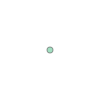

In [28]:
gdf_business.loc[0,"geometry"] - neighborhoods.loc[0, 'geometry']

In [17]:
gdf_neigh = neighborhoods

In [19]:
gdf_joined = gpd.sjoin(
    gdf_business,
    gdf_neigh[['name', 'geometry']],
    how='left',
    predicate='within'
)


In [20]:
gdf_joined.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,...,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,index_right,name
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,...,Hardware stores,0,10/01/2020,NaN,"(33.9581, -118.2926)",33.96,-118.29,POINT (-118.2926 33.9581),NaN,NaN
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,...,NaN,8,09/03/2020,NaN,"(33.9597, -118.3028)",33.96,-118.30,POINT (-118.3028 33.9597),35.00,Gramercy Park
2,0003249387-0001-0,"CHOE SHOW, LLC",NaN,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,711 GRAMERCY 90005,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,...,NaN,5,03/15/2021,NaN,"(34.0594, -118.3135)",34.06,-118.31,POINT (-118.3135 34.0594),52.00,Koreatown
3,0003240128-0001-1,SANTOS ANTONIO RAMOS AJPACAJA,NaN,19948 SATICOY STREET,WINNETKA,91306-2648,19948 Saticoy 91306-2648,NaN,NaN,NaN,...,Other services to buildings & dwellings,3,01/15/2019,NaN,"(34.2081, -118.5684)",34.21,-118.57,POINT (-118.5684 34.2081),111.00,Winnetka
4,0003236037-0001-9,ASHLEY-ANN FELIX,NaN,412 W 7TH STREET,SAN PEDRO,90731-3208,412 7TH 90731,465 N HANFORD AVENUE,SAN PEDRO,90732-2621,...,NaN,15,03/01/2021,NaN,"(33.738, -118.2861)",33.74,-118.29,POINT (-118.2861 33.738),79.00,San Pedro


In [30]:
gdf_joined.columns

Index(['LOCATION ACCOUNT #', 'BUSINESS NAME', 'DBA NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'LOCATION DESCRIPTION', 'MAILING ADDRESS',
       'MAILING CITY', 'MAILING ZIP CODE', 'NAICS',
       'PRIMARY NAICS DESCRIPTION', 'COUNCIL DISTRICT', 'LOCATION START DATE',
       'LOCATION END DATE', 'LOCATION', 'Latitude', 'Longitude', 'geometry',
       'index_right', 'name'],
      dtype='object')

In [22]:
gdf_joined[['BUSINESS NAME', 'Latitude', 'Longitude', 'name']].head()

,BUSINESS NAME,Latitude,Longitude,name
0,MARIA OFELIA NUNEZ,33.96,-118.29,NaN
1,ONE STOP HOLISTIC HEALTH LLC,33.96,-118.30,Gramercy Park
2,"CHOE SHOW, LLC",34.06,-118.31,Koreatown
3,SANTOS ANTONIO RAMOS AJPACAJA,34.21,-118.57,Winnetka
4,ASHLEY-ANN FELIX,33.74,-118.29,San Pedro


In [24]:
len(gdf_joined["name"].unique())

115

In [26]:
gdf_joined['name'].isnull().sum()/len(gdf_joined)

np.float64(0.21837311403070098)

In [34]:
# 1. Separa lo asignado y lo faltante
gdf_missing  = gdf_joined[gdf_joined['name'].isna()].copy()
gdf_assigned = gdf_joined[gdf_joined['name'].notna()].copy()

if gdf_missing.empty:
    print("No quedan puntos sin vecindario.")
else:
    # 2. Elimina 'index_right' si quedó de operaciones previas
    for gdf in (gdf_missing, gdf_neigh):
        gdf.drop(columns=['index_right'], errors='ignore', inplace=True)

    # 3. Unión al polígono más cercano
    gdf_nearest = gpd.sjoin_nearest(
        gdf_missing,
        gdf_neigh[['name', 'geometry']],
        how='left',
        lsuffix='_bus',
        rsuffix='_neigh',
        distance_col='dist_m',
        max_distance=0.05      # ~2 km → 0.02 grados; ajusta
    )

    # 4. Combina resultados
    gdf_final = pd.concat([gdf_assigned, gdf_nearest], ignore_index=True)

    # 5. Comprueba
    print(gdf_final['name'].isna().sum(), "puntos siguen sin vecindario")
    print(gdf_final[['BUSINESS NAME', 'Latitude', 'Longitude', 'name', 'dist_m']].head())


/home/rigodev/.pyenv/versions/3.12.0/lib/python3.12/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


146287 puntos siguen sin vecindario
                   BUSINESS NAME  Latitude  Longitude           name  dist_m
0   ONE STOP HOLISTIC HEALTH LLC     33.96    -118.30  Gramercy Park     NaN
1                 CHOE SHOW, LLC     34.06    -118.31      Koreatown     NaN
2  SANTOS ANTONIO RAMOS AJPACAJA     34.21    -118.57       Winnetka     NaN
3               ASHLEY-ANN FELIX     33.74    -118.29      San Pedro     NaN
4                 FRESH AIR HVAC     34.10    -118.35      Hollywood     NaN


In [44]:
# A) CRS local en metros (NAD83 / California zone 5, EPSG:6423)
gdf_bus_m   = gdf_missing.to_crs("EPSG:6423")
gdf_neigh_m = gdf_neigh.to_crs("EPSG:6423")

# B) Unión al polígono más cercano con radio máximo
gdf_near_m = gpd.sjoin_nearest(
    gdf_bus_m,
    gdf_neigh_m[['name', 'geometry']],
    how='left',
    max_distance=4000,        # 400 m ≈ media manzana‐gran avenida
    distance_col='dist_m'
).to_crs(gdf_missing.crs)    # vuelve a WGS‑84 si quieres

# Combinar…
gdf_final = pd.concat([gdf_assigned, gdf_near_m], ignore_index=True)

In [45]:
gdf_final['name'].isnull().sum()/len(gdf_final)

np.float64(0.21837544765279907)

In [40]:
buffer_m = 200    # 200 m
gdf_buf = gdf_neigh_m.copy()
gdf_buf['geometry'] = gdf_buf.geometry.buffer(buffer_m)

gdf_join_buf = gpd.sjoin(
    gdf_missing.to_crs("EPSG:6423"),
    gdf_buf[['name', 'geometry']],
    how='left',
    predicate='within'
).to_crs(gdf_missing.crs)

In [42]:
gdf_join_buf

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,...,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Latitude,Longitude,geometry,name_left,index_right,name_right
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,...,0,10/01/2020,NaN,"(33.9581, -118.2926)",33.96,-118.29,POINT (-118.2926 33.9581),NaN,98.00,Vermont Knolls
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,...,0,10/01/2020,NaN,"(33.9581, -118.2926)",33.96,-118.29,POINT (-118.2926 33.9581),NaN,101.00,Vermont Vista
6,0003227519-0001-2,H2ORGANICS PRODUCTS INC,NaN,1205 W 90TH STREET,LOS ANGELES,90044-2029,1205 90TH,NaN,NaN,NaN,...,0,01/02/2021,NaN,"(33.9562, -118.2963)",33.96,-118.30,POINT (-118.2963 33.9562),NaN,NaN,NaN
7,0003213030-0001-2,JESSE LUNA,BUSINESS RESCUE AGENCY,1107 FAIR OAKS AVENUE UNIT #156,SOUTH PASADENA,91030-3311,1107 FAIR OAKS 91030-3311,NaN,NaN,NaN,...,0,10/01/2020,NaN,"(34.1135, -118.1505)",34.11,-118.15,POINT (-118.1505 34.1135),NaN,NaN,NaN
11,0003239021-0001-0,CHRISTINA SCAVUZZO,NaN,2396 N ROBINHOOD PLACE,ORANGE,92867-1851,2396 ROBINHOOD 92867,2396 N ROBINHOOD PLACE,ORANGE,92867-1851,...,0,01/07/2020,NaN,"(33.8286, -117.8324)",33.83,-117.83,POINT (-117.8324 33.8286),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607905,0003159837-0001-3,"CHRISTIAN MANAGEMENT SERVICES, LLC",NaN,13101 W WASHINGTON BLVD SUITE #215,LOS ANGELES,90066-5173,13101 Washington 90066-5173,28305 N BRUCE ROAD,CHATTAROY,99003-9755,...,0,09/01/2019,NaN,"(33.9941, -118.4411)",33.99,-118.44,POINT (-118.4411 33.9941),NaN,22.00,Del Rey
1607905,0003159837-0001-3,"CHRISTIAN MANAGEMENT SERVICES, LLC",NaN,13101 W WASHINGTON BLVD SUITE #215,LOS ANGELES,90066-5173,13101 Washington 90066-5173,28305 N BRUCE ROAD,CHATTAROY,99003-9755,...,0,09/01/2019,NaN,"(33.9941, -118.4411)",33.99,-118.44,POINT (-118.4411 33.9941),NaN,59.00,Mar Vista
1607910,0003466125-0001-4,CRAIG STALEY,WESTLAN CONSTRUCTION,2950 FLORENTINE COURT,THOUSAND OAKS,91362-1762,2950 FLORENTINE 91362-1762,2950 FLORENTINE COURT,THOUSAND OAKS,91362,...,0,01/10/2025,NaN,"(34.2172, -118.8225)",34.22,-118.82,POINT (-118.8225 34.2172),NaN,NaN,NaN
1607911,0002513340-0001-2,K.A.T. EQUIPMENT RENTALS INC,K.A.T. RENTALS,161 E ORANGETHORPE AVENUE UNIT #21,PLACENTIA,92870-6435,161 ORANGETHORPE 92870-6435,14656 RODEO DRIVE,VICTORVILLE,92395-4133,...,0,07/21/2010,NaN,"(33.864, -117.8716)",33.86,-117.87,POINT (-117.8716 33.864),NaN,NaN,NaN


In [ ]:

import numpy as np

# Centroides en radianes (Haversine)
neigh_cent = gdf_neigh[['name', 'geometry']].copy()
neigh_cent['centroid'] = neigh_cent.geometry.centroid
centroids = np.deg2rad(
    np.c_[neigh_cent.centroid.y.values, neigh_cent.centroid.x.values]
)
tree = BallTree(centroids, metric='haversine')

# Puntos faltantes → radianes
pts = np.deg2rad(np.c_[gdf_missing.geometry.y, gdf_missing.geometry.x])
dist, idx = tree.query(pts, k=1)

gdf_missing['name']   = neigh_cent.iloc[idx.flatten()].name.values
gdf_missing['dist_k'] = dist.flatten()*6371   # km


/tmp/ipykernel_14125/1203483220.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neigh_cent['centroid'] = neigh_cent.geometry.centroid
/tmp/ipykernel_14125/1203483220.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  np.c_[neigh_cent.centroid.y.values, neigh_cent.centroid.x.values]


In [48]:
gdf_missing['name'].isnull().sum()/len(gdf_missing)

np.float64(0.0)

In [36]:
gdf_final

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,...,LOCATION,Latitude,Longitude,geometry,index_right,name,name__bus,index__neigh,name__neigh,dist_m
0,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,...,"(33.9597, -118.3028)",33.96,-118.30,POINT (-118.3028 33.9597),35.00,Gramercy Park,NaN,NaN,NaN,NaN
1,0003249387-0001-0,"CHOE SHOW, LLC",NaN,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,711 GRAMERCY 90005,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,...,"(34.0594, -118.3135)",34.06,-118.31,POINT (-118.3135 34.0594),52.00,Koreatown,NaN,NaN,NaN,NaN
2,0003240128-0001-1,SANTOS ANTONIO RAMOS AJPACAJA,NaN,19948 SATICOY STREET,WINNETKA,91306-2648,19948 Saticoy 91306-2648,NaN,NaN,NaN,...,"(34.2081, -118.5684)",34.21,-118.57,POINT (-118.5684 34.2081),111.00,Winnetka,NaN,NaN,NaN,NaN
3,0003236037-0001-9,ASHLEY-ANN FELIX,NaN,412 W 7TH STREET,SAN PEDRO,90731-3208,412 7TH 90731,465 N HANFORD AVENUE,SAN PEDRO,90732-2621,...,"(33.738, -118.2861)",33.74,-118.29,POINT (-118.2861 33.738),79.00,San Pedro,NaN,NaN,NaN,NaN
4,0003206130-0001-6,FRESH AIR HVAC,NaN,7270 FRANKLIN AVENUE APT #105,LOS ANGELES,90046-3057,7270 Franklin 90046-3057,NaN,NaN,NaN,...,"(34.1031, -118.3485)",34.10,-118.35,POINT (-118.3485 34.1031),49.00,Hollywood,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669879,0002652435-0001-3,JACENT M MPALYENKANA,NaN,37448 DAYBREAK STREET,PALMDALE,93550-2504,37448 DAYBREAK 93550-2504,37448 DAYBREAK STREET,PALMDALE,93550-2504,...,"(34.5626, -118.0616)",34.56,-118.06,POINT (-118.0616 34.5626),NaN,NaN,NaN,NaN,NaN,NaN
669880,0003159837-0001-3,"CHRISTIAN MANAGEMENT SERVICES, LLC",NaN,13101 W WASHINGTON BLVD SUITE #215,LOS ANGELES,90066-5173,13101 Washington 90066-5173,28305 N BRUCE ROAD,CHATTAROY,99003-9755,...,"(33.9941, -118.4411)",33.99,-118.44,POINT (-118.4411 33.9941),NaN,NaN,NaN,59.00,Mar Vista,0.00
669881,0003466125-0001-4,CRAIG STALEY,WESTLAN CONSTRUCTION,2950 FLORENTINE COURT,THOUSAND OAKS,91362-1762,2950 FLORENTINE 91362-1762,2950 FLORENTINE COURT,THOUSAND OAKS,91362,...,"(34.2172, -118.8225)",34.22,-118.82,POINT (-118.8225 34.2172),NaN,NaN,NaN,NaN,NaN,NaN
669882,0002513340-0001-2,K.A.T. EQUIPMENT RENTALS INC,K.A.T. RENTALS,161 E ORANGETHORPE AVENUE UNIT #21,PLACENTIA,92870-6435,161 ORANGETHORPE 92870-6435,14656 RODEO DRIVE,VICTORVILLE,92395-4133,...,"(33.864, -117.8716)",33.86,-117.87,POINT (-117.8716 33.864),NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
with open('ruta/a/tu_archivo.json', 'r', encoding='utf-8') as f:
    data = json.load(f)   

NameError: name 'df_result' is not defined

In [6]:
business_df.columns = business_df.columns.str.strip()

business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607924 entries, 0 to 1607923
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   LOCATION ACCOUNT #         1607924 non-null  object 
 1   BUSINESS NAME              1607924 non-null  object 
 2   DBA NAME                   246256 non-null   object 
 3   STREET ADDRESS             1607822 non-null  object 
 4   CITY                       1607814 non-null  object 
 5   ZIP CODE                   1607924 non-null  object 
 6   LOCATION DESCRIPTION       1607801 non-null  object 
 7   MAILING ADDRESS            369932 non-null   object 
 8   MAILING CITY               369944 non-null   object 
 9   MAILING ZIP CODE           369813 non-null   object 
 10  NAICS                      628889 non-null   float64
 11  PRIMARY NAICS DESCRIPTION  628889 non-null   object 
 12  COUNCIL DISTRICT           1607924 non-null  int64  
 13  LOCATION STA

In [7]:
business_df["LOCATION START DATE"] = pd.to_datetime(business_df["LOCATION START DATE"], format="%m/%d/%Y", errors='coerce')
business_df["LOCATION END DATE"] = pd.to_datetime(business_df["LOCATION END DATE"], format="%m/%d/%Y", errors='coerce')

In [8]:
hoy = pd.Timestamp.now()

#Diferencia
result = (business_df["LOCATION END DATE"].fillna(hoy) - business_df["LOCATION START DATE"]).dt.days
result = round(result/365,0)

# Columna con la edad de la sociedad
business_df["AGE"] = result

business_df["AGE"].head()

0   5.00
1   5.00
2   7.00
3   8.00
4   4.00
Name: AGE, dtype: float64

Parece que tememos un problema con el calculo de AGE pues tenemos resultados negativos, por lo que realizaremos una inspección más a fondo de su naturaleza.

In [10]:
business_df.describe()

,NAICS,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,AGE
count,"628,889.00","1,607,924.00",1606366,1010608,"1,606,366.00"
mean,"546,537.56",5.89,2006-11-18 23:22:51.861206784,2010-03-01 16:43:33.466745088,8.91
min,"111,110.00",0.00,1920-01-01 00:00:00,1943-02-01 00:00:00,-40.00
25%,"451,110.00",0.00,2000-04-20 00:00:00,2004-08-28 00:00:00,2.00
50%,"541,100.00",5.00,2007-09-30 00:00:00,2010-01-25 00:00:00,6.00
75%,"624,410.00",11.00,2015-10-01 00:00:00,2016-01-01 00:00:00,12.00
max,"999,999.00",15.00,2025-12-31 00:00:00,2030-07-02 00:00:00,104.00
std,"166,037.71",5.13,NaN,NaN,9.70


Existe 1558 registros que cuentan con un valor nulo de la edad.

In [23]:
mask = business_df["AGE"].isnull()

business_df.loc[mask, :]

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,AGE
523,0000014535-0001-9,BENENSON DANSON,NaN,6922 HOLLYWOOD BLVD #402,LOS ANGELES,90028-6117,6922 HOLLYWOOD 90028-6117,NaN,NaN,NaN,NaN,NaN,13,NaT,2014-08-15,NaN,NaN
864,0000027257-0001-9,PAMELA RAE TRIPP,NaN,10727 WHITE OAK AVENUE #100,GRANADA HILLS,91344-4636,10727 WHITE OAK 91344-4636,NaN,NaN,NaN,NaN,NaN,12,NaT,2004-09-09,NaN,NaN
2376,0000125786-0001-7,JERID R MAY BAUM,NaN,523 W 6TH STREET #1228,LOS ANGELES,90014-1218,523 6TH 90014-1218,NaN,NaN,NaN,NaN,NaN,9,NaT,2009-11-19,NaN,NaN
2837,0000204234-0001-4,LEO BURNETT,NaN,2417 MCKINLEY AVENUE,VENICE,90291-4625,2417 MCKINLEY 90291,NaN,NaN,NaN,NaN,NaN,11,NaT,2004-08-30,NaN,NaN
3038,0000245130-0001-1,JOE/MARY LOU TELLEZ,NaN,10555 SAN FERNANDO ROAD #36 38,PACOIMA,91331-2624,10555 SAN FERNANDO 91331-2624,NaN,NaN,NaN,NaN,NaN,7,NaT,2015-12-31,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571442,0000011648-0001-2,S/S BURBANK PLAZA LLC,NaN,12410 BURBANK BLVD,N HOLLYWOOD,91607-1692,12410 BURBANK 91607-1692,NaN,NaN,NaN,NaN,NaN,2,NaT,2024-12-31,NaN,NaN
1584380,0000014476-0001-0,CINDY LEVIN,NaN,2029 CENTURY PARKS E #6FL,LOS ANGELES,90067-2901,2029 CENTURY 90067-2901,NaN,NaN,NaN,NaN,NaN,5,NaT,2000-06-26,NaN,NaN
1587308,0000624491-0001-3,HARVER DEUTSCH MD,NaN,2070 CENTURY PARKS E,LOS ANGELES,90067-1907,2070 CENTURY 90067-1907,NaN,NaN,NaN,NaN,NaN,5,NaT,1997-10-21,NaN,NaN
1588714,0000995993-0001-1,BARRY VOUGHAN,NaN,2029 CENTURY PARKS E,LOS ANGELES,90067-2901,2029 CENTURY 90067-2901,NaN,NaN,NaN,NaN,NaN,5,NaT,2000-06-01,NaN,NaN


In [11]:
business_df["YEAR START"] = business_df["LOCATION START DATE"].dt.year
business_df["YEAR END"] = business_df["LOCATION END DATE"].dt.year
business_df["MONTH END"] = business_df["LOCATION END DATE"].dt.month
business_df["MONTH START"] = business_df["LOCATION START DATE"].dt.month

Identificando los registros con datos nulos

In [14]:
business_df.isnull().sum()/len(business_df)

LOCATION ACCOUNT #          0.00
BUSINESS NAME               0.00
DBA NAME                    0.85
STREET ADDRESS              0.00
CITY                        0.00
ZIP CODE                    0.00
LOCATION DESCRIPTION        0.00
MAILING ADDRESS             0.77
MAILING CITY                0.77
MAILING ZIP CODE            0.77
NAICS                       0.61
PRIMARY NAICS DESCRIPTION   0.61
COUNCIL DISTRICT            0.00
LOCATION START DATE         0.00
LOCATION END DATE           0.37
LOCATION                    0.58
AGE                         0.00
YEAR START                  0.00
YEAR END                    0.37
MONTH END                   0.37
MONTH START                 0.00
dtype: float64

Acotando los registros del df a solo la ciudad de los angeles

In [12]:
business_df.loc[:, "CITY"].value_counts()/len(business_df)

CITY
LOS ANGELES                  0.49
VAN NUYS                     0.04
SHERMAN OAKS                 0.02
NORTH HOLLYWOOD              0.02
WOODLAND HILLS               0.02
                             ... 
KITCHENER, ONTARIO N2G 4X8   0.00
LOS ANELES                   0.00
RANCHITA                     0.00
EDINBURGH EH1 3AN            0.00
YOKNEAU ISRAEL               0.00
Name: count, Length: 6418, dtype: float64

In [13]:
mask = business_df.loc[:, "CITY"] == "LOS ANGELES"

angeles_bussines_df = business_df.loc[mask, :]

angeles_bussines_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 785808 entries, 0 to 1607923
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   LOCATION ACCOUNT #         785808 non-null  object        
 1   BUSINESS NAME              785808 non-null  object        
 2   DBA NAME                   116121 non-null  object        
 3   STREET ADDRESS             785729 non-null  object        
 4   CITY                       785808 non-null  object        
 5   ZIP CODE                   785808 non-null  object        
 6   LOCATION DESCRIPTION       785707 non-null  object        
 7   MAILING ADDRESS            181549 non-null  object        
 8   MAILING CITY               181558 non-null  object        
 9   MAILING ZIP CODE           181510 non-null  object        
 10  NAICS                      305484 non-null  float64       
 11  PRIMARY NAICS DESCRIPTION  305484 non-null  object      

In [15]:
angeles_bussines_df.isnull().sum()/len(angeles_bussines_df)

LOCATION ACCOUNT #          0.00
BUSINESS NAME               0.00
DBA NAME                    0.85
STREET ADDRESS              0.00
CITY                        0.00
ZIP CODE                    0.00
LOCATION DESCRIPTION        0.00
MAILING ADDRESS             0.77
MAILING CITY                0.77
MAILING ZIP CODE            0.77
NAICS                       0.61
PRIMARY NAICS DESCRIPTION   0.61
COUNCIL DISTRICT            0.00
LOCATION START DATE         0.00
LOCATION END DATE           0.36
LOCATION                    0.58
AGE                         0.00
YEAR START                  0.00
YEAR END                    0.36
MONTH END                   0.36
MONTH START                 0.00
dtype: float64

In [16]:
angeles_bussines_df["AGE"].sort_values(ascending=True).head(10)

80040    -40.00
721437   -36.00
764148   -31.00
137507   -28.00
705254   -27.00
750013   -25.00
511963   -25.00
776403   -22.00
961278   -20.00
470859   -19.00
Name: AGE, dtype: float64

In [73]:
len(angeles_bussines_df.loc[:, "ZIP CODE"].unique())

131561

In [94]:
len(angeles_bussines_df.loc[:, "NAICS"].unique())

751

In [76]:
angeles_bussines_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,...,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,AGE,YEAR START,YEAR END,MONTH END,MONTH START
0,0003217523-0001-2,MARIA OFELIA NUNEZ,LA CAMPANA HARDWARE,1017 W 88TH STREET,LOS ANGELES,90044-2119,1017 88TH 90044,1017 W 88TH STREET,LOS ANGELES,90044-2119,...,Hardware stores,0,2020-10-01,NaT,"(33.9581, -118.2926)",5.00,"2,020.00",NaN,NaN,10.00
1,0003211603-0001-0,ONE STOP HOLISTIC HEALTH LLC,NaN,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,1506 MANCHESTER 90047,1506 W MANCHESTER AVENUE,LOS ANGELES,90047-5424,...,NaN,8,2020-09-03,NaT,"(33.9597, -118.3028)",5.00,"2,020.00",NaN,NaN,9.00
2,0003249387-0001-0,"CHOE SHOW, LLC",NaN,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,711 GRAMERCY 90005,711 S GRAMERCY PLACE,LOS ANGELES,90005-3166,...,NaN,5,2021-03-15,NaT,"(34.0594, -118.3135)",4.00,"2,021.00",NaN,NaN,3.00
5,0003206130-0001-6,FRESH AIR HVAC,NaN,7270 FRANKLIN AVENUE APT #105,LOS ANGELES,90046-3057,7270 Franklin 90046-3057,NaN,NaN,NaN,...,"Plumbing, Heating, and Air-Conditioning Contra...",4,2020-08-05,NaT,"(34.1031, -118.3485)",5.00,"2,020.00",NaN,NaN,8.00
6,0003227519-0001-2,H2ORGANICS PRODUCTS INC,NaN,1205 W 90TH STREET,LOS ANGELES,90044-2029,1205 90TH,NaN,NaN,NaN,...,Wholesale trade agents & brokers,0,2021-01-02,NaT,"(33.9562, -118.2963)",4.00,"2,021.00",NaN,NaN,1.00


In [88]:
group_by_year_start = angeles_bussines_df.groupby("YEAR START").agg({"YEAR START": "count", "NAICS": "count"})
group_by_year_start.reset_index(inplace=True, names="YEAR")

group_by_year_start

,YEAR,YEAR START,NAICS
0,"1,920.00",1,0
1,"1,926.00",1,0
2,"1,929.00",2,1
3,"1,930.00",1,1
4,"1,934.00",4,3
...,...,...,...
90,"2,021.00",18387,12981
91,"2,022.00",15729,12647
92,"2,023.00",14438,12080
93,"2,024.00",12958,11924


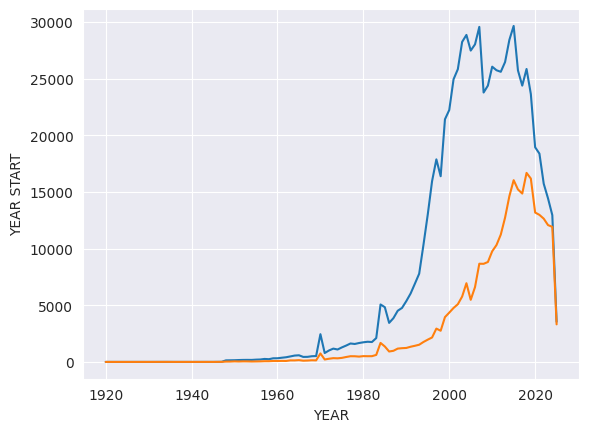

In [91]:
sns.lineplot(group_by_year_start, x="YEAR", y="YEAR START")
sns.lineplot(group_by_year_start, x="YEAR", y="NAICS")

plt.show()

In [ ]:
mask = angeles_bussines_df.loc[:, "NAICS"].value_counts()/len(angeles_bussines_df)>.001

## Limpieza y tratamiento de datos

Para este primer proceso de limpieza y preprocesamiento de datos, se ajustaran algunos campos los cuales cuentan con caracteristicas o valores que no tiene sentido logico alguno en la base de datos.

In [27]:
mask = angeles_bussines_df["LOCATION END DATE"] < angeles_bussines_df["LOCATION START DATE"]

angeles_bussines_df.loc[mask, ["AGE", "LOCATION START DATE", "LOCATION END DATE", "YEAR START", "YEAR END", "MONTH END", "MONTH START"]]


,AGE,LOCATION START DATE,LOCATION END DATE,YEAR START,YEAR END,MONTH END,MONTH START
4129,-0.00,2004-02-01,2004-01-07,"2,004.00","2,004.00",1.00,2.00
6833,-5.00,2007-01-01,2002-01-01,"2,007.00","2,002.00",1.00,1.00
6840,-5.00,2007-01-01,2002-01-01,"2,007.00","2,002.00",1.00,1.00
6846,-5.00,2007-01-01,2002-01-01,"2,007.00","2,002.00",1.00,1.00
7063,-5.00,2007-01-01,2002-01-01,"2,007.00","2,002.00",1.00,1.00
...,...,...,...,...,...,...,...
1580766,-12.00,2002-01-01,1990-06-07,"2,002.00","1,990.00",6.00,1.00
1596227,-6.00,2007-01-01,2001-01-01,"2,007.00","2,001.00",1.00,1.00
1601063,-1.00,2015-10-01,2015-01-01,"2,015.00","2,015.00",1.00,10.00
1605021,-1.00,2007-01-01,2006-03-09,"2,007.00","2,006.00",3.00,1.00


In [ ]:
angeles_error_fecha = angeles_bussines_df.loc[mask, list(angeles_bussines_df.columns)]

In [29]:
angeles_error_fecha.groupby("YEAR START").agg({"AGE": "count", "LOCATION START DATE": "count", "LOCATION END DATE": "count", "YEAR END": "count", "MONTH END": "count", "MONTH START": "count"}).reset_index(names="YEAR")

,YEAR,AGE,LOCATION START DATE,LOCATION END DATE,YEAR END,MONTH END,MONTH START
0,"1,984.00",1,1,1,1,1,1
1,"1,994.00",1,1,1,1,1,1
2,"1,997.00",1,1,1,1,1,1
3,"1,999.00",2,2,2,2,2,2
4,"2,000.00",1,1,1,1,1,1
5,"2,001.00",4,4,4,4,4,4
6,"2,002.00",3,3,3,3,3,3
7,"2,003.00",15,15,15,15,15,15
8,"2,004.00",15,15,15,15,15,15
9,"2,005.00",11,11,11,11,11,11


In [30]:
angeles_error_fecha.describe()

,NAICS,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,AGE,YEAR START,YEAR END,MONTH END,MONTH START
count,7.00,378.00,378,378,378.00,378.00,378.00,378.00,378.00
mean,"465,111.43",7.46,2007-04-24 09:27:37.142857216,2003-07-21 10:36:11.428571392,-3.76,"2,007.23","2,003.28",4.07,1.88
min,"238,990.00",0.00,1984-02-09 00:00:00,1970-09-15 00:00:00,-40.00,"1,984.00","1,970.00",1.00,1.00
25%,"453,990.00",4.00,2007-01-01 00:00:00,2002-01-01 00:00:00,-5.00,"2,007.00","2,002.00",1.00,1.00
50%,"522,100.00",9.00,2007-01-01 00:00:00,2004-01-01 00:00:00,-3.00,"2,007.00","2,004.00",1.00,1.00
75%,"527,210.00",11.00,2007-01-01 00:00:00,2006-01-01 00:00:00,-1.00,"2,007.00","2,006.00",7.00,1.00
max,"532,290.00",15.00,2023-03-30 00:00:00,2018-11-05 00:00:00,-0.00,"2,023.00","2,018.00",12.00,12.00
std,"105,581.73",4.48,NaN,NaN,5.05,3.35,5.92,3.93,2.33


In [33]:
mask = angeles_error_fecha["YEAR START"] == 2007

angeles_error_fecha.loc[mask, :]

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,...,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,AGE,YEAR START,YEAR END,MONTH END,MONTH START
6833,0002237554-0001-6,JOSEPH TAKI EDEN,NaN,NaN,LOS ANGELES,-,NaN,NaN,NaN,NaN,...,NaN,0,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
6840,0002238391-0001-8,KEVIN MAX HAUB,NaN,NaN,LOS ANGELES,-,NaN,NaN,NaN,NaN,...,NaN,0,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
6846,0002239287-0001-1,MICHAEL ANTHONY MARTINEZ,NaN,902 15TH PLACE,LOS ANGELES,-,902 15TH,NaN,NaN,NaN,...,NaN,0,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
7063,0002281309-0001-2,DEPORTES GUADALAJARA,NaN,1316 E FLORENCE AVENUE,LOS ANGELES,90001-1935,1316 FLORENCE 90001-1935,NaN,NaN,NaN,...,NaN,0,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
7521,0002375517-0001-1,ROBERT RICHTER MD,NaN,6360 WILSHIRE BLVD SUITE #203,LOS ANGELES,90048-5606,6360 WILSHIRE 90048-5606,NaN,NaN,NaN,...,NaN,5,2007-01-01,2005-01-01,NaN,-2.00,"2,007.00","2,005.00",1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318142,0002397502-0001-2,TIERRA LOAN CENTER INC,NaN,6345 BALBOA BLVD UNIT #231,LOS ANGELES,-,6345 BALBOA,NaN,NaN,NaN,...,NaN,0,2007-01-01,2006-06-26,NaN,-1.00,"2,007.00","2,006.00",6.00,1.00
1357343,0002089482-0001-5,MAM FINANCIAL,NaN,1801 CENTURY PARKS E #2400,LOS ANGELES,90067-2326,1801 CENTURY 90067-2326,NaN,NaN,NaN,...,NaN,5,2007-01-01,2002-01-01,NaN,-5.00,"2,007.00","2,002.00",1.00,1.00
1382261,0002164709-0001-9,RENESANS DEVELOPMENT CORP,NaN,1855 INDUSTRIAL STREET UNIT #312,LOS ANGELES,90021-1256,1855 INDUSTRIAL 90021-1256,NaN,NaN,NaN,...,NaN,14,2007-01-01,2005-01-10,NaN,-2.00,"2,007.00","2,005.00",1.00,1.00
1596227,0002470968-0001-6,ALDRICH LAW GROUP LLC,NaN,1800 CENTURY PARKS E #600,LOS ANGELES,90067-1508,1800 CENTURY 90067-1508,NaN,NaN,NaN,...,NaN,5,2007-01-01,2001-01-01,NaN,-6.00,"2,007.00","2,001.00",1.00,1.00


In [ ]:
angeles_error_fecha.loc[mask, :]